<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# NWL Fire Emissions Article

**Analysis of emissions due to fires and comparison with carbon flux estimates from literature**

_By Oriana Chegwidden_

March 30, 2022



In [1]:
%load_ext watermark

from pathlib import PosixPath
import matplotlib.pyplot as plt
import xarray as xr

import numpy as np
import fsspec
import pandas as pd

import json
import gcsfs
import numcodecs
from carbonplan_styles.mpl import set_theme

from gfed import return_gfed_emissions, C_TO_CO2_CONVERSION

work_dir = PosixPath().cwd()

write_spatial = True

set_theme()

In [2]:
%watermark -u -i -v -m -g -iv

Last updated: 2022-03-30T19:01:51.771521+00:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.10.2

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.4.170+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 79428de79fc5bc7639d68d1cbc68dc2fcdb8ddbb

fsspec    : 2021.10.1
json      : 2.0.9
pandas    : 1.3.4
numcodecs : 0.9.1
matplotlib: 3.4.3
numpy     : 1.20.3
xarray    : 0.19.0
gcsfs     : 2021.10.1



# Calculate fire emissions based on GFED


In [3]:
CO2_df, full_ds = return_gfed_emissions(start_year=2000, end_year=2021, return_spatial=True)

  0%|          | 0/22 [00:00<?, ?it/s]/srv/conda/envs/notebook/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:
100%|██████████| 22/22 [02:13<00:00,  6.06s/it]


# Save the GFED files to repo for safe keeping


In [4]:
if write_spatial:
    storage_options = {"verify_ssl": False}
    fs = gcsfs.GCSFileSystem()
    cloud_bucket = "gs://carbonplan-nwl"
    encoding = {"emissions MMT CO2/year": {"compressor": numcodecs.Blosc()}}
    store = fsspec.get_mapper(cloud_bucket + "/data/GFED_annual_emissions_CO2.zarr")
    full_ds.to_zarr(store, mode="w", encoding=encoding)

# Total greenhouse gas emisisons from California Air Resources Board


Load in 2021 CARB GHG Emissions Inventory from https://ww2.arb.ca.gov/ghg-inventory-data.

File:
https://ww3.arb.ca.gov/cc/inventory/pubs/reports/2000_2019/2000_2019_ghg_inventory_trends_figures.xlsx


In [5]:
ghg_california_emissions_carb = pd.read_excel(
    work_dir / "2000_2019_ghg_inventory_trends_figures.xlsx"
)
ghg_california_emissions_carb = pd.Series(
    list(ghg_california_emissions_carb.loc[4].values[2:]),
    index=pd.date_range("2000", "2020", freq="Y"),
)

# Collate the greenhouse gas and fire emissions estimates


Initialize the dataframe with fires.


In [6]:
full_emissions_df = pd.DataFrame(CO2_df, columns=["Fire (GFED)"])

Since 2019 is the most recent year for which we have GHG estimates we'll just assume the emissions
for 2020-2021 were the same as 2019. We know that this assumption has error, largely due to the
COVID-19 pandemic, but these numbers will largely be used for illustrative purposes and do not
expect any updates to change the overall story.


In [7]:
full_emissions_df["Anthropogenic GHG Inventory"] = ghg_california_emissions_carb

Forward fill 2020 and 2021 with 2019 estimates for GHG inventory


In [8]:
full_emissions_df.iloc[-1, 1] = full_emissions_df.iloc[-3, 1]
full_emissions_df.iloc[-2, 1] = full_emissions_df.iloc[-3, 1]

Then add in CARB's fire estimates from CARB's _Wildfire Emission Estimates for 2020_. Data accessed
here: https://ww2.arb.ca.gov/wildfire-emissions

File: Wildfire Emissions & Burned Area Estimates 2000–2020 located at
https://ww2.arb.ca.gov/sites/default/files/2021-07/Wildfire%20Emission%20Estimates%20for%202020%20_Final.pdf

Numbers are digitized into the `carb_wildfire_estimates_2020.txt` file in this directory.


In [9]:
carb_fire = pd.read_csv(work_dir / "carb_wildfire_estimates_2020.txt", header=None)
carb_fire = pd.Series(carb_fire[1].values, index=pd.date_range("2000", "2021", freq="Y"))
full_emissions_df["Fire (CARB)"] = carb_fire

In [10]:
full_emissions_df.head()

,Fire (GFED),Anthropogenic GHG Inventory,Fire (CARB)
2000-12-31,6.571791,468.0,5.4
2001-12-31,6.057294,483.1,6.2
2002-12-31,6.971701,482.7,13.5
2003-12-31,7.649050,482.8,18.3
2004-12-31,5.993434,490.8,5.2


Let's first just write out a df with just the variables for the blog post we're considering right
now. Jeremy will use this to make a nice set of initial figures.


# Figure 1: How do California's GHG emissions compare to their 2020 target set by AB32 (431 MMT CO2)


Text(0, 0.5, 'CO2 Emissions [MMT]')

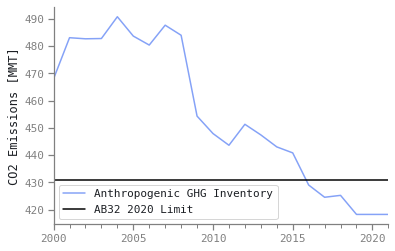

In [11]:
full_emissions_df[
    [
        "Anthropogenic GHG Inventory",
    ]
].plot()
plt.axhline(431, color="k", label="AB32 2020 Limit")
plt.legend()
plt.ylabel("CO2 Emissions [MMT]")

From the above plot it might like a big reduction in emissions but if we zero-out the y-axis we see
that emissions reductions aren't that significant percentage-wise.


(0.0, 494.43)

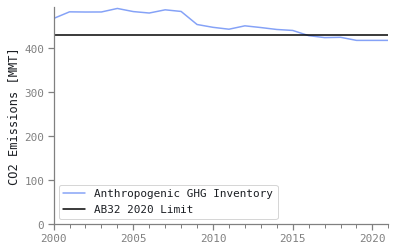

In [12]:
full_emissions_df[
    [
        "Anthropogenic GHG Inventory",
    ]
].plot()
plt.axhline(431, color="k", label="AB32 2020 Limit")
plt.ylabel("CO2 Emissions [MMT]")
plt.legend()
plt.ylim(0)

We'll write out these numbers to creat our web article.


In [13]:
figure1_json = {}
figure1_json["ghg_inventory"] = (
    np.array(
        [
            full_emissions_df.index.year.values,
            full_emissions_df[["Anthropogenic GHG Inventory"]].values.squeeze(),
        ]
    )
    .transpose()
    .tolist()
)
figure1_json["AB32"] = 431  # The target for
with open(work_dir / "figure1.json", "w") as outfile:
    json.dump(figure1_json, outfile)

# Figure 2: What about fire emissions?

What do fire emissions look like over time? CARB provides estimates, but they haven't yet released
2021's estimates. Let's use GFED to get a preview. And along the way, let's compare the estimates to
see how they might differ.


Text(0, 0.5, 'CO2 Emissions [MMT]')

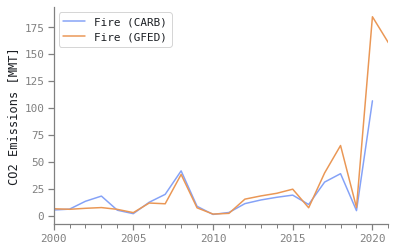

In [14]:
fig, ax = plt.subplots()
full_emissions_df[["Fire (CARB)", "Fire (GFED)"]].plot(ax=ax)
plt.ylabel("CO2 Emissions [MMT]")

And let's write out those numbers to JSON


In [15]:
figure2_json = {}
for dataset in ["Fire (CARB)", "Fire (GFED)"]:
    figure2_json[dataset] = (
        np.array(
            [full_emissions_df.index.year.values, full_emissions_df[[dataset]].values.squeeze()]
        )
        .transpose()
        .tolist()
    )
with open(work_dir / "figure2.json", "w") as outfile:
    json.dump(figure2_json, outfile)

# Calculating the appropriate time periods to match the estimates in the literature


Calculating emissions based upon annual timeseries and differences between multiyear averages are
different methods. Thus, it can be tricky to align annual emissions timeseries with emissions
calculated based upon stock-difference approaches from multiyear averages of FIA data. Based upon
understandings of FIA inventory approaches we will assume that fluxes calculated by comparing
inventories from two periods, (`first_period_startyear` to `first_period_endyear`) and
(`second_period_startyear` to `second_period_endyear`) will be representative of average fluxes from
(`first_period_endyear` to `second_period_endyear`) exclusive. We spell out the details of those
assumptions below.


Defining how we handle time periods (because it is tricky!):

- If FIA period sampling - sampling time period (`period_startyear` - `period_endyear`) we assume
  the `period_endyear` is the year it is representative of. Conceptually, we can say that if a fire
  went through in an earlier year we would have captured that loss in carbon by accesing the
  `period_endyear`.
- Now we can think of the FIA sampling periods as corresponding to difference between two years, and
  create annualized average stock change estimates across the period between those two years.
- In aligning the annualized estimates with fire emissions we use emissions from the years after
  that time period ends. As an example, Christensen et al (2001-2005)-(2011-2015) carbon flux
  estimates we'll align with fires 2006-2015 (inclusive).
- For Gonzalez et al (2015) it is more simple example since they use Landfire- their time period is
  2001-2010 so we'll use 2002-2010 (inclusive).


# Collate net carbon flux estimates from the literature


The literature includes a range of estimates of forest carbon fluxes. Here we collect them, note
their provenance, keep track of the time periods which they cover, and note any nuances for each
data source.


### AB 1504 California Forest Ecosystem and Harvested Wood Product Carbon Inventory


First, estimates from Christensen et al. _AB 1504 California Forest Ecosystem and Harvested Wood
Product Carbon Inventory: 2017 Reporting Period. Final Report._ Febraury 13, 2019.  
The estimates below are in MMT CO2e and do not include contributions from the harvested wood
products. They released updated these numbers twice with additional reports (releasing reports in
2015, 2016, and 2017). Holland et al (described below) reference the numbers from the 2015 report.


In [16]:
# all slices here are INCLUSIVE
net_options = {
    "holland_et_al_2019": {
        "value": -4.5 * C_TO_CO2_CONVERSION,
        "range": slice("2007", "2016"),
    },  # periods (10 years)- this is the number they recommend in final conclusion
    "gonzalez_et_al_2015": {
        "value": 4.8
        * C_TO_CO2_CONVERSION,  # trees only # also available: wildland ecosystems (-6.9), trees and shrubland (-7.1)
        "range": slice("2002", "2010"),
    },  # all land excluding crops and settlements
    "ab1504_2015": {
        "value": -6.5 * C_TO_CO2_CONVERSION,  # AB1504 2015 estimate for standing live tree
        "range": slice("2006", "2015"),
    },
    "ab1504_2019": {"value": -13.091, "range": slice("2010", "2019")},  # already in CO2
}

In [17]:
net_options_json = {
    "holland_et_al_2019_periods": {"value": -4.5 * C_TO_CO2_CONVERSION, "range": [2007, 2016]},
    "gonzalez_et_al_2015": {
        "value": 4.8 * C_TO_CO2_CONVERSION,
        "range": [2002, 2010],
    },  # all land excluding crops and settlements
    "ab1504_2015": {
        "value": -6.5 * C_TO_CO2_CONVERSION,
        "range": [2006, 2015],
    },  # they only did trees so it's a little hard to compare
    "ab1504_2019": {
        "value": -3.58 * C_TO_CO2_CONVERSION,  # -13.091/C_TO_CO2_CONVERSION
        "range": [2010, 2019],
    },  # (plots measured (2001-2007) compared to (2011-2017)
}

In [18]:
with open(work_dir / "figure3.json", "w") as outfile:
    json.dump(net_options_json, outfile)

So the values above represent the net effect of forests from the sources and sinks from California
vegetation. We also have emissions due to fires calculated in two different ways by CARB and GFED
above. We'll first translate the AGC vegetation effects into CO2 and then subtract out our fire
emissions to get the non-fire effect. We'll assume that this is largely due to vegetation
sequestration. It will likely be low-biased as we do not remove any effects of droughts or insect
(esp. bark beetle) effects. It's worthwhile to note that Holland et al (2019) stress that while the
remote sensing based techniques are more highly biased when doing inventory analysis for growth they
_are_ useful for change mapping (like is done in by the CARB/GFED estimates!). So, we're essentially
trusting the robust estimates from Holland et al (2019) do a good growth model, but then remove a
credible fire emissions effect.


Since Holland et al (2019) calculated it based upon changes in stocks between (2001-2005) and
(2011-2015), we should align with them in our fire analyses to maintain consistency. So, we'll do
2001-2015.


In [19]:
accounting_method = "holland_et_al_2019"
fire_method = "Fire (CARB)"

In [20]:
fire_effect = full_emissions_df[fire_method].loc[net_options[accounting_method]["range"]].mean()
net_effect = net_options[accounting_method]["value"]
vegetation_uptake = net_effect - fire_effect

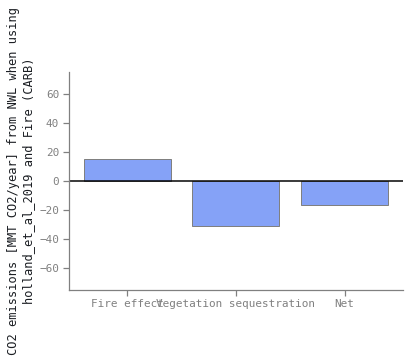

In [21]:
plt.bar(
    ["Fire effect", "Vegetation sequestration", "Net"],
    np.array([fire_effect, vegetation_uptake, net_effect]),
)
plt.ylabel(
    "CO2 emissions [MMT CO2/year] from NWL when using\n"
    "{} and {}".format(accounting_method, fire_method)
)
plt.ylim(-75, 75)
plt.axhline(0, color="k")

Now we'll assume the vegetation sequestration is the same. We don't really know for sure (it's so
tricky to figure out) but we'll just assume that since Holland et al (2019) did a good job we'll
trust them. But we'll sub in the average annual fire effect like it's been for the past 15 years and
update the net effect.


Caveats:

    * assumes no effect of a giant regrowth due to large fires in later part of record


Instead if we took the vegetation sequestration from Christensen and applied the fire estimates we
could also create an updated net effect.


Now let's add the "net emissions" assuming constant vegetation sequestration and variable fire
effects to each year of the GHG inventory.


In [22]:
full_emissions_df["Vegetation sequestration"] = vegetation_uptake
full_emissions_df["Net forest effect"] = (
    full_emissions_df[fire_method] + full_emissions_df["Vegetation sequestration"]
)
full_emissions_df["Anthropogenic + Forests GHG Inventory"] = (
    full_emissions_df["Anthropogenic GHG Inventory"] + full_emissions_df["Net forest effect"]
)

(0.0, 499.59499999999997)

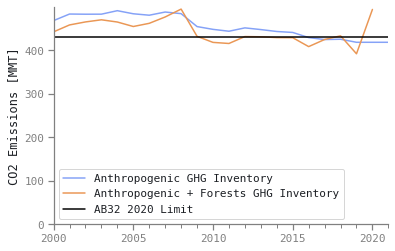

In [23]:
full_emissions_df[["Anthropogenic GHG Inventory", "Anthropogenic + Forests GHG Inventory"]].plot()

plt.axhline(431, color="k", label="AB32 2020 Limit")
plt.ylabel("CO2 Emissions [MMT]")
plt.legend()
plt.ylim(0)